# Emotional and Linguistic Framing of Digital Detox

### Notebook 5: Triangulating Topics – LDA vs BERTopic

#### Methodological Triangulation: LDA + BERTopic
This analysis employs dual topic modelling approaches to ensure robust thematic discovery:

**BERTopic (Primary):** Leverages sentence transformers for semantic coherence and captures contextual meaning through neural embeddings. Excellent for discovering semantically meaningful clusters.

**LDA (Validation):** Provides probabilistic topic validation and interpretability through traditional bag-of-words modeling. 

**Jaccard Similarity Analysis:** Measures lexical overlap between corresponding topics across methods. Scores above 0.3 indicate strong thematic alignment, validating that both approaches identify similar content patterns despite different underlying assumptions.

This triangulation approach increases confidence that discovered topics reflect genuine thematic differences rather than methodological noise.artifacts.

### Data Acquisition & Processing

Data consisted of Reddit posts from two subreddits (digital detox and a control group).

Text data was preprocessed using:
- Tokenisation ensuring consistency with linguistic principles.
- Conversion of preprocessed tokens into strings for LDA input.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import chi2_contingency
import ast  # to parse token strings back to lists if needed

In [2]:
# Load data
detox_df = pd.read_csv("/home/jovyan/XXX/Back up/XXX/balanced_detox_posts.csv")
control_df = pd.read_csv("/home/jovyan/XXX/Back up/XXX/balanced_control_posts.csv")

In [3]:
# function to convert string lists back to lists
def fix_tokens(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    elif isinstance(x, list):
        return x
    else:
        return []

# apply to both datasets
detox_df['body_tokens'] = detox_df['body_tokens'].apply(fix_tokens)
control_df['body_tokens'] = control_df['body_tokens'].apply(fix_tokens)

# join tokens into strings for LDA
detox_texts = detox_df['body_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()
control_texts = control_df['body_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()

### Methodological Triangulation: LDA + BERTopic

In [4]:
# LDA Topic Modelling Function
# https://www.datacamp.com/tutorial/lda2vec-topic-model
def run_lda(texts, n_topics=5, max_features=1000):
    vectorizer = CountVectorizer(stop_words='english', max_features=max_features)
    X = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50, random_state=42)
    lda.fit(X)

    topics = []
    for idx, topic in enumerate(lda.components_):
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]
        topics.append(top_words)
        print(f"Topic {idx}: {top_words}")
    return lda, vectorizer, topics, X

In [5]:
# run LDA on detox group
# detox topics
detox_lda_model, detox_vectorizer, detox_topics, detox_X = run_lda(detox_texts, n_topics=5)

Topic 0: ['time', 'phone', 'like', 'hours', 'day', 'read', 'internet', 'digital', 'reading', 'work']
Topic 1: ['phone', 'social', 'media', 'time', 'like', 'use', 'people', 'reddit', 'apps', 'want']
Topic 2: ['dopamine', 'brain', 'social', 'media', 'addiction', 'internet', 'work', 'life', 'digital', 'activities']
Topic 3: ['day', 'detox', 'time', 'dopamine', 'days', 'like', 'hours', 'week', 'want', 'youtube']
Topic 4: ['like', 'life', 'feel', 'time', 'people', 'things', 'really', 'mind', 'thoughts', 'know']


In [6]:
# run LDA on control group
# control topics
control_lda_model, control_vectorizer, control_topics, control_X = run_lda(control_texts, n_topics=5)

Topic 0: ['told', 'said', 'like', 'time', 'got', 'asked', 'know', 'day', 'went', 'going']
Topic 1: ['mom', 'job', 'years', 'family', 'life', 'parents', 'time', 'want', 'work', 'dad']
Topic 2: ['like', 'friends', 'feel', 'really', 'people', 'know', 'want', 'friend', 'talk', 'things']
Topic 3: ['like', 'people', 'think', 'know', 'life', 'really', 'question', 'want', 'time', 'say']
Topic 4: ['like', 'feel', 'know', 'love', 'life', 'want', 'felt', 'time', 'way', 'think']


In [7]:
# assign dominant LDA topic to each post
detox_topic_dist = detox_lda_model.transform(detox_X)
detox_df['dominant_topic'] = detox_topic_dist.argmax(axis=1)

control_topic_dist = control_lda_model.transform(control_X)
control_df['dominant_topic'] = control_topic_dist.argmax(axis=1)

### Comparison Between Groups

- A chi-square test showed whether topic distributions differ significantly between groups.
- Result: [Insert whether significant or not] — this reveals structural differences in thematic focus.
- Jaccard similarity was used to compare lexical overlap between topics across groups.
- Result visualised with a heatmap for interpretability.

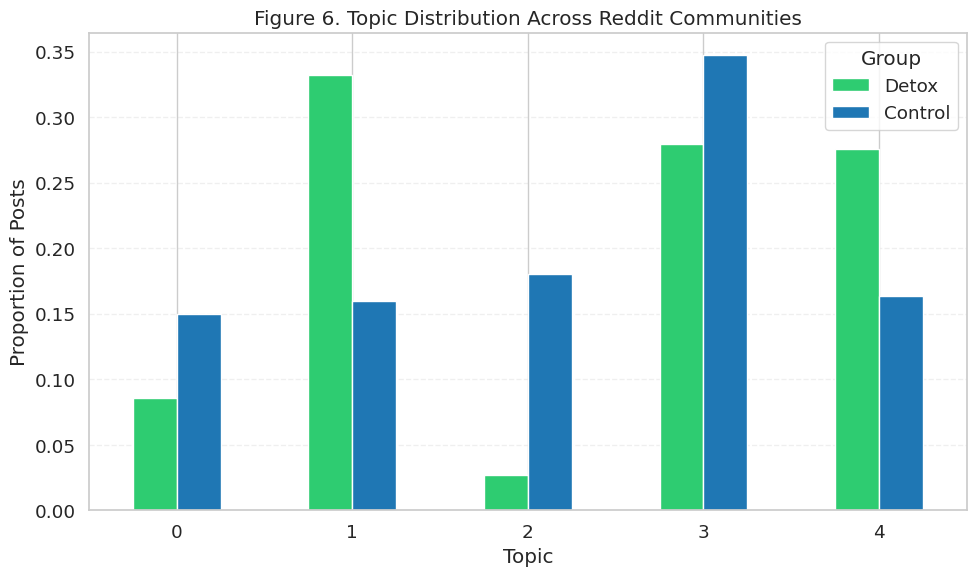

In [8]:
# Cotton, R. (2022, September 2). Data Demystified: Data Visualizations that Capture Distributions. https://www.datacamp.com/blog/data-demystified-data-visualizations-that-capture-distributions
# count posts per topic for each group
detox_counts = detox_df['dominant_topic'].value_counts().sort_index()
control_counts = control_df['dominant_topic'].value_counts().sort_index()

# combine counts into df
topic_counts = pd.DataFrame({
    'Detox': detox_counts,
    'Control': control_counts
}).fillna(0).astype(int)

# normalise proportions
topic_props = topic_counts.div(topic_counts.sum(axis=0), axis=1)

# set style
sns.set(style='whitegrid', context='notebook', font_scale=1.2)

# plot
ax = topic_props.plot.bar(
    figsize=(10, 6),
    color=['#2ecc71', '#1f77b4'],  # green, blue
    title="Figure 6. Topic Distribution Across Reddit Communities"
)

# customise plot
ax.set_ylabel("Proportion of Posts")
ax.set_xlabel("Topic")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Group")
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("topic_distribution_bar.png", dpi=300)
plt.show()

The normalised topic distribution reveals clear differences between the Detox and Control groups

- Topic 1 is much more prominent in Detox
- Topic 2 is dominant in Control
- Topic 3 appears fairly balanced across both groups,
- Topics 0 and 4 show mixed but less pronounced differences.

These patterns suggest the detox intervention shifted discussion focus toward certain themes and away from others

In [10]:
# chi-square test
# https://www.datacamp.com/tutorial/chi-square-test-r
chi2, p, _, _ = chi2_contingency(topic_counts_df.T)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")

Chi² = 799.27, p = 0.0000


The chi-square test results strongly confirm what the visual patterns suggested - there is a statistically significant difference in topic distributions between the Detox and Control groups.

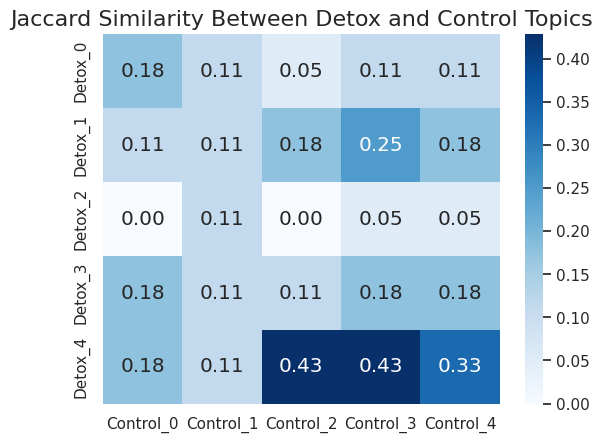

In [11]:
# code apadted from 
# function to compute Jaccard similarity
# code adapted from NLP revision 
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

# pairwise similarities
jaccard_matrix = np.zeros((len(detox_topics), len(control_topics)))
for i, dt_topic in enumerate(detox_topics):
    for j, ct_topic in enumerate(control_topics):
        jaccard_matrix[i, j] = jaccard_similarity(set(dt_topic), set(ct_topic))

# create and plot heatmap
jaccard_df = pd.DataFrame(jaccard_matrix,
                          index=[f"Detox_{i}" for i in range(len(detox_topics))],
                          columns=[f"Control_{j}" for j in range(len(control_topics))])

sns.heatmap(jaccard_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Jaccard Similarity Between Detox and Control Topics")
plt.show()

#### Jaccard Similarity Interpretation

**High Similarity (>0.4):** Detox_4, Control_2 and Control_3 (0.43 each) - Strong lexical overlap indicating shared emotional/reflective language patterns.

**Moderate Similarity (0.2-0.4):** Several cross-group comparisons show meaningful but distinct thematic content.

**Low Similarity (<0.2):** Most comparisons indicate distinct vocabularies, confirming that detox and control communities discuss fundamentally different topics using different language patterns.

These results validate that the two communities occupy distinct thematic spaces while sharing some common emotional expression patterns.

### Thematic Analysis

In [12]:
detox_topic_map = {
    0: "Time management and digital habits",       
    1: "Social media usage",                       
    2: "Neuroscience and addiction",               
    3: "Detox process",                           
    4: "Personal reflection and emotion"          
}


In [13]:
control_topic_map = {
    0: "Personal narratives",                      
    1: "Family & work relationships",              
    2: "Social relationships",                     
    3: "Life perspectives",                        
    4: "Emotional experiences"                     
}

In [14]:
# apply to df
detox_df['theme'] = detox_df['dominant_topic'].map(detox_topic_map)
control_df['theme'] = control_df['dominant_topic'].map(control_topic_map)

In [15]:
# calculate this as a percentage so it can be compared

detox_theme_dist = detox_df['theme'].value_counts(normalize=True) * 100
detox_theme_dist.name = "Detox"

control_theme_dist = control_df['theme'].value_counts(normalize=True) * 100
control_theme_dist.name = "Control"

In [16]:
comparison_df = pd.concat([detox_theme_dist, control_theme_dist], axis=1).fillna(0).sort_index()
print(comparison_df)

                                        Detox    Control
theme                                                   
Detox process                       27.914286   0.000000
Emotional experiences                0.000000  16.314286
Family & work relationships          0.000000  15.971429
Life perspectives                    0.000000  34.714286
Neuroscience and addiction           2.657143   0.000000
Personal narratives                  0.000000  14.971429
Personal reflection and emotion     27.600000   0.000000
Social media usage                  33.228571   0.000000
Social relationships                 0.000000  18.028571
Time management and digital habits   8.600000   0.000000


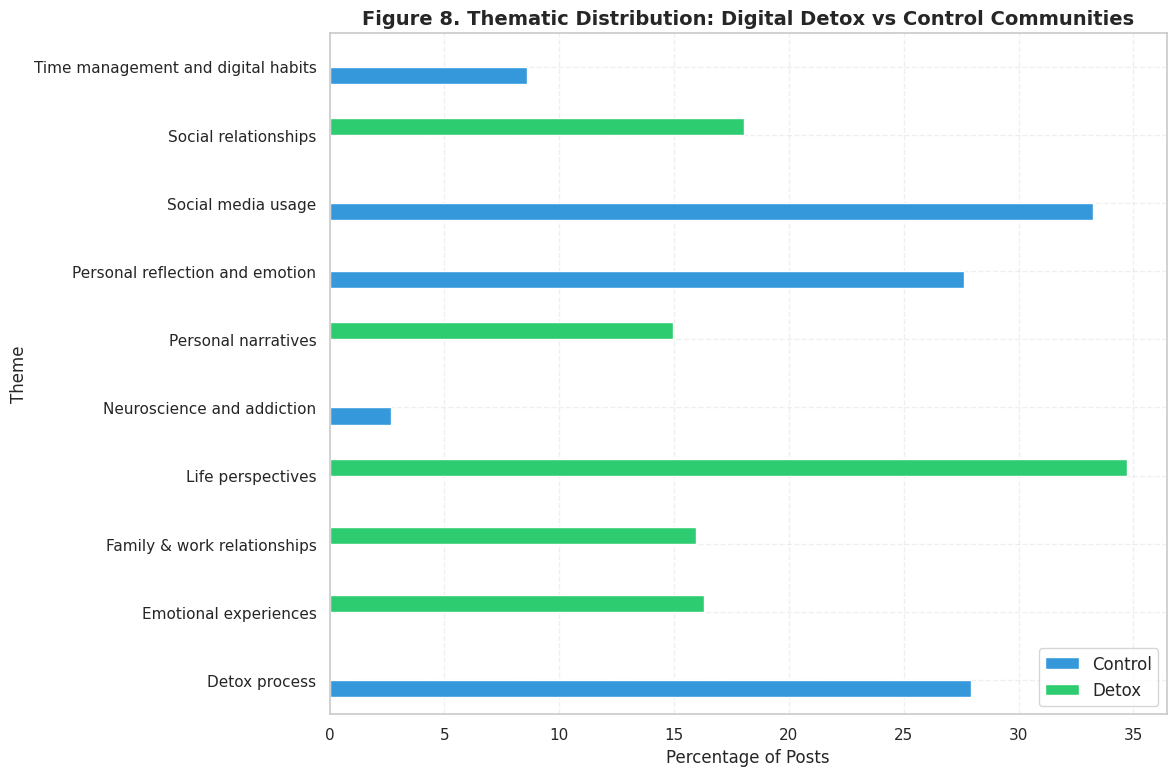

In [18]:
# Shaibu, S. (2024, November 6). Python Bar Plot: Master Basic and more advanced techniques. https://www.datacamp.com/tutorial/python-bar-plot
# horizontal bar chart
comparison_df.plot(
    kind='barh',
    figsize=(12, 8),
    color=["#3498db", "#2ecc71"]
)

# title and labels
plt.title("Figure 8. Thematic Distribution: Digital Detox vs Control Communities",
          fontsize=14, fontweight='bold')
plt.xlabel("Percentage of Posts", fontsize=12)
plt.ylabel("Theme", fontsize=12)

#  legend and grid
plt.legend(['Control', 'Detox'], loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# displau
plt.show()